In [1]:
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Visualization

Vẽ các biểu đồ sepal length với petal length, sepal width với petal length.

In [2]:
import matplotlib.pyplot as plt

feats = iris['feature_names']
i = 0
j = 1

plt.figure(figsize = (6, 4))
plt.scatter(X[:, i], X[:, j])
plt.xlabel(feats[i])
plt.ylabel(feats[j])
plt.title("{} vs {}".format(feats[i], feats[j]))
plt.show()

<Figure size 600x400 with 1 Axes>

Text(0.5, 0.98, 'Iris scale')

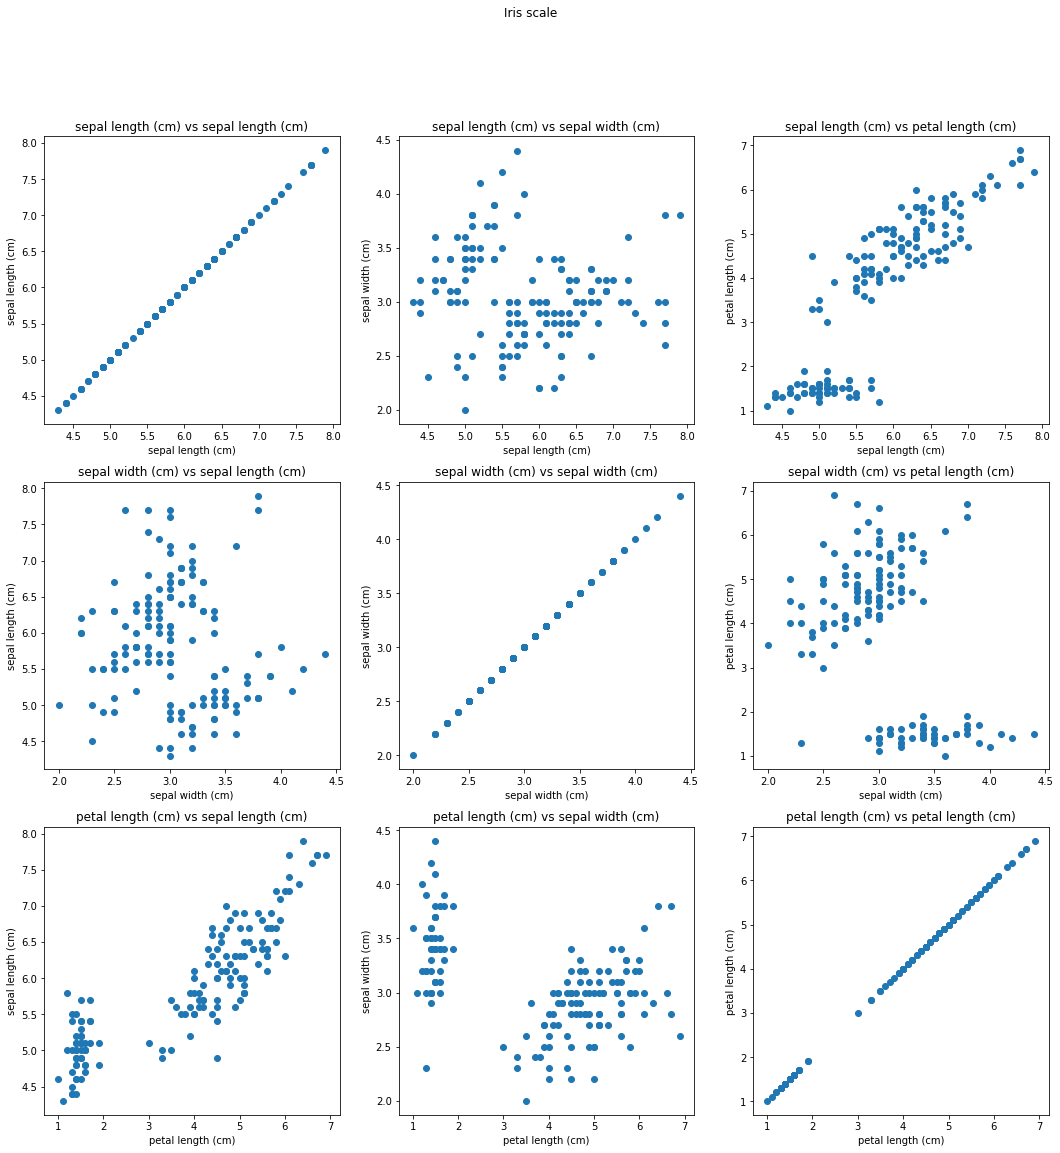

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18))
for i in range(3):
    for j in range(3):
        ax[i, j].scatter(X[:, i], X[:, j])
        ax[i, j].set_xlabel(feats[i])
        ax[i, j].set_ylabel(feats[j])
        ax[i, j].set_title("{} vs {}".format(feats[i], feats[j]))

fig.suptitle("Iris scale")

Đếm số lượng loài hoa mỗi loại

Text(0.5, 1.0, 'Species count')

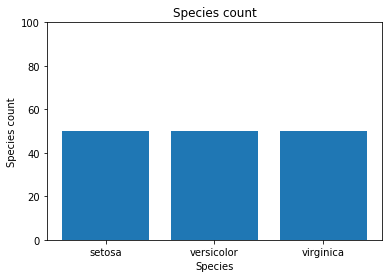

In [4]:
import numpy as np
spec_count = np.unique(y, return_counts = True)
plt.bar(x = iris['target_names'], height = spec_count[1])
plt.xlabel("Species")
plt.ylabel("Species count")
plt.ylim([0, 100])
plt.title("Species count")

Phân biệt theo các chiều kích thước của mỗi loài hoa

In [5]:
columns = iris['feature_names'] + ['Species']
df_iris = pd.DataFrame(np.concatenate((X, np.expand_dims(y, -1)), axis = 1), columns = columns)
df_iris.head()
# plt.bar(x = iris["target_names"], height = X[:, :])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Text(0.5, 1.0, 'Iris average scale vs Species')

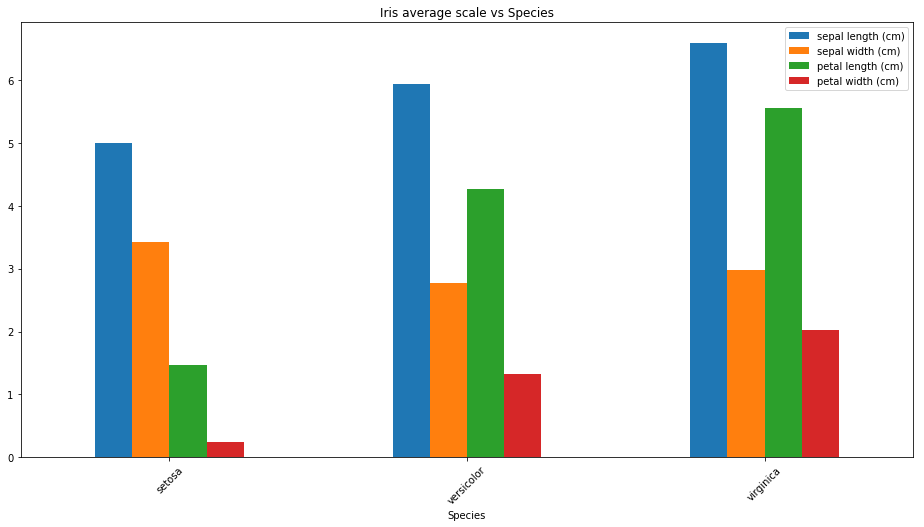

In [6]:
df_iris.groupby('Species').mean().plot.bar(figsize = (16, 8))
plt.xticks(ticks = np.array([0, 1, 2]), labels = iris['target_names'], rotation=45)
plt.xlabel("Species")
plt.title("Iris average scale vs Species")

# Xây dựng model

Đầu tiên chúng ta sẽ phân chia tập train/test theo tỷ lệ 80/20

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(120, 4)
(120,)
(30, 4)
(30,)


Tập train dùng để huấn luyện model. Tập test để kiểm tra lại kết quả huấn luyện.

Tiếp theo ta sẽ thiết kế kiến trúc model.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Kiến trúc model sẽ bao gồm Input(4) -> Dense(32) -> Dense(16) -> Dense(8) -> output(3)

inp = Input(shape = (4,))
den1 = Dense(units = 32, activation = 'relu')(inp)
den2 = Dense(units = 16, activation = 'relu')(den1)
den3 = Dense(units = 8, activation = 'relu')(den2)
# outp = Dense(units = 3, activation = K.sigmoid)(den3)
den4 = Dense(units = 3)(den3)
# outp = Activation(activation = K.sigmoid)(den4)
outp = Activation('sigmoid')(den4)

model = Model(inputs = [inp], outputs = [outp])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 851
Trainable params: 851
Non-trainable params: 0
_______________________________________________________________

Để huấn luyện được thì phải gán optimizer và khai báo loss function vào model

In [38]:
import tensorflow.keras.backend as K

opt = Adam()

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def accuracy_topk(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(loss = "sparse_categorical_crossentropy",
              optimizers = opt,
              metrics = ['mae', 'acc'])

Lưu ý: Đối với mô hình phân loại thì hàm loss function là crossentropy, mô hình dự báo là mean square error.
Trường hợp mô hình phân loại, tùy vào giá trị biến dự báo mà ta sẽ lựa chọn hàm loss function phù hợp:

* Dạng vector categorical one-hot ([1, 0, 0]): Sử dụng hàm categorical_crossentropy
* Dạng số nguyên (1,2,3): Sử dụng hàm sparse_categorical_crossentropy
* Biến nhị phân ([0, 1]): Sử dụng hàm binary_crossentropy

In [10]:
# Hoặc cách khác
y_oh = tf.keras.utils.to_categorical(y, num_classes = 3)
y_oh[:5, :]

# --> sử dụng loss function là categorical_crossentropy

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

Huấn luyện mô hình

In [39]:
model.fit(x = X_train, y = y_train,
            validation_data = (X_test, y_test),
            epochs = 10,
            batch_size = 16
           )

Train on 120 samples, validate on 30 samples
Epoch 1/10
120/120 [==============================] - 0s 4ms/sample - loss: 0.7749 - mae: 0.7766 - acc: 0.8167 - val_loss: 0.7401 - val_mae: 0.7706 - val_acc: 0.9000
Epoch 2/10
120/120 [==============================] - 0s 158us/sample - loss: 0.7476 - mae: 0.7693 - acc: 0.8167 - val_loss: 0.7202 - val_mae: 0.7655 - val_acc: 0.9000
Epoch 3/10
120/120 [==============================] - 0s 175us/sample - loss: 0.7233 - mae: 0.7638 - acc: 0.8583 - val_loss: 0.7013 - val_mae: 0.7608 - val_acc: 0.9333
Epoch 4/10
120/120 [==============================] - 0s 208us/sample - loss: 0.7065 - mae: 0.7584 - acc: 0.8917 - val_loss: 0.6832 - val_mae: 0.7569 - val_acc: 0.9000
Epoch 5/10
120/120 [==============================] - 0s 208us/sample - loss: 0.6882 - mae: 0.7543 - acc: 0.8917 - val_loss: 0.6656 - val_mae: 0.7578 - val_acc: 0.8333
Epoch 6/10
120/120 [==============================] - 0s 200us/sample - loss: 0.6726 - mae: 0.7528 - acc: 0.8667 - va

Có thể sử dụng thêm callback function để lưu model. Có các lựa chọn:

Sử dụng ModelCheckpoints
* Lưu model tốt nhất
* Lưu model sau một period epochs

Sử dụng EarlyStopping:
* Dừng sớm quá trình huấn luyện

### Model checkpoints

In [40]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cur_dir = os.getcwd()
# Lưu model tốt nhất hoặc lưu sau p epochs
final_dir = os.path.join(cur_dir, "save_best")
if not os.path.exists(final_dir):
    os.mkdir(final_dir)
    
final_dir = os.path.join(cur_dir, "all_ckp")    
if not os.path.exists(final_dir):
    os.mkdir(final_dir)
    
best_checkpointer = ModelCheckpoint(filepath='save_best',  monitor='val_accuracy', 
                                   verbose=0, 
                                   save_best_only=True, # Chỉ lưu model lẫn hệ số
                                   save_weights_only=False, # Chỉ lưu hệ số
                                   save_freq=1, # Khoảng cách epochs để lưu checkpoints
                                   mode = "max"
                                  )

all_checkpointer = ModelCheckpoint(filepath='all_ckp',  monitor='val_accuracy', 
                                   verbose=0, 
                                   save_best_only=False, # Chỉ lưu model lẫn hệ số
                                   save_weights_only=False, # Chỉ lưu hệ số
                                   save_freq=1, # Khoảng cách epochs để lưu checkpoints
                                   mode="max"
                                  )

model.fit(x = X_train, y = y_train,
            validation_data = (X_test, y_test),
            epochs = 10,
            batch_size = 32,
            callbacks = [best_checkpointer, all_checkpointer]
          )

W0227 16:21:14.014611 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Train on 120 samples, validate on 30 samples
Epoch 1/10


W0227 16:21:14.554671 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.540060). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.6353 - mae: 0.8225 - acc: 0.8750

W0227 16:21:14.557706 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:15.116016 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.548669). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5805 - mae: 0.7875 - acc: 0.9062

W0227 16:21:15.117987 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:15.650003 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.540060). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5758 - mae: 0.7473 - acc: 0.8750

W0227 16:21:15.652970 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:16.177282 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.536038). Check your callbacks.


120/120 [==============================] - 2s 18ms/sample - loss: 0.5817 - mae: 0.7451 - acc: 0.8917 - val_loss: 0.5576 - val_mae: 0.7455 - val_acc: 0.9333


W0227 16:21:16.190279 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 2/10


W0227 16:21:16.715114 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.525837). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.6172 - mae: 0.7248 - acc: 0.9062

W0227 16:21:16.717082 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:17.270951 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.539853). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5878 - mae: 0.7527 - acc: 0.9219

W0227 16:21:17.273917 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:17.833942 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.553870). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5809 - mae: 0.7420 - acc: 0.9062

W0227 16:21:17.836943 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:18.384150 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.551039). Check your callbacks.


120/120 [==============================] - 2s 18ms/sample - loss: 0.5714 - mae: 0.7430 - acc: 0.9000 - val_loss: 0.5470 - val_mae: 0.7476 - val_acc: 0.9000


W0227 16:21:18.395112 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 3/10


W0227 16:21:18.953570 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.558458). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5356 - mae: 0.6571 - acc: 0.8750

W0227 16:21:18.956541 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:19.884855 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.743385). Check your callbacks.


 64/120 [===============>..............] - ETA: 1s - loss: 0.5478 - mae: 0.6884 - acc: 0.8906

W0227 16:21:19.886855 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:20.412265 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.558458). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5753 - mae: 0.7117 - acc: 0.8958

W0227 16:21:20.414265 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:20.965135 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.554664). Check your callbacks.


120/120 [==============================] - 3s 22ms/sample - loss: 0.5607 - mae: 0.7430 - acc: 0.9083 - val_loss: 0.5405 - val_mae: 0.7546 - val_acc: 0.8000


W0227 16:21:20.975138 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 4/10


W0227 16:21:21.549170 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.573031). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5248 - mae: 0.7939 - acc: 0.9062

W0227 16:21:21.551171 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:22.087762 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.554811). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5288 - mae: 0.7304 - acc: 0.8750

W0227 16:21:22.090766 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:22.645998 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.555231). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5256 - mae: 0.7612 - acc: 0.8750

W0227 16:21:22.647998 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:23.173757 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.545911). Check your callbacks.


120/120 [==============================] - 2s 18ms/sample - loss: 0.5524 - mae: 0.7500 - acc: 0.8500 - val_loss: 0.5329 - val_mae: 0.7417 - val_acc: 1.0000


W0227 16:21:23.184722 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 5/10


W0227 16:21:23.737213 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.552491). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5239 - mae: 0.8174 - acc: 0.9688

W0227 16:21:23.740212 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:24.286213 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.549246). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5611 - mae: 0.7733 - acc: 0.9062

W0227 16:21:24.289215 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:24.835212 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.546001). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5519 - mae: 0.7429 - acc: 0.9062

W0227 16:21:24.838213 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:25.436001 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.549246). Check your callbacks.


120/120 [==============================] - 2s 19ms/sample - loss: 0.5444 - mae: 0.7430 - acc: 0.9000 - val_loss: 0.5162 - val_mae: 0.7485 - val_acc: 0.9333


W0227 16:21:25.448002 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 6/10


W0227 16:21:25.997202 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.549200). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5375 - mae: 0.7604 - acc: 0.8750

W0227 16:21:26.000211 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:26.573851 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.561419). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5493 - mae: 0.7244 - acc: 0.8750

W0227 16:21:26.576853 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:27.586849 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.573639). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5499 - mae: 0.7219 - acc: 0.9062

W0227 16:21:27.589851 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:28.125849 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.561419). Check your callbacks.


120/120 [==============================] - 3s 22ms/sample - loss: 0.5315 - mae: 0.7444 - acc: 0.9167 - val_loss: 0.5116 - val_mae: 0.7578 - val_acc: 0.8000


W0227 16:21:28.137851 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 7/10


W0227 16:21:28.730883 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.593032). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5605 - mae: 0.6691 - acc: 0.8125

W0227 16:21:28.733851 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:29.278015 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.568598). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5296 - mae: 0.7249 - acc: 0.8750

W0227 16:21:29.281016 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:29.816015 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.544164). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5455 - mae: 0.7517 - acc: 0.8542

W0227 16:21:29.819020 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:30.384000 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.554571). Check your callbacks.


120/120 [==============================] - 2s 19ms/sample - loss: 0.5278 - mae: 0.7494 - acc: 0.8750 - val_loss: 0.4965 - val_mae: 0.7526 - val_acc: 0.8667


W0227 16:21:30.395001 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 8/10


W0227 16:21:30.968428 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.572443). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5090 - mae: 0.7936 - acc: 0.8125

W0227 16:21:30.971420 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:31.586675 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.593349). Check your callbacks.


 64/120 [===============>..............] - ETA: 1s - loss: 0.5243 - mae: 0.7105 - acc: 0.8438

W0227 16:21:31.588671 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:32.227629 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.614255). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5115 - mae: 0.7478 - acc: 0.8750

W0227 16:21:32.232637 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:32.785208 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.593349). Check your callbacks.


120/120 [==============================] - 2s 20ms/sample - loss: 0.5147 - mae: 0.7489 - acc: 0.8750 - val_loss: 0.4871 - val_mae: 0.7517 - val_acc: 0.9667


W0227 16:21:32.798170 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 9/10


W0227 16:21:33.342169 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.543999). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5298 - mae: 0.7928 - acc: 0.9688

W0227 16:21:33.345170 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:33.896168 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.547498). Check your callbacks.


 64/120 [===============>..............] - ETA: 0s - loss: 0.5334 - mae: 0.7470 - acc: 0.8594

W0227 16:21:33.899173 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:34.445169 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.546965). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.5119 - mae: 0.7385 - acc: 0.8854

W0227 16:21:34.448167 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:35.006705 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.548981). Check your callbacks.


120/120 [==============================] - 2s 18ms/sample - loss: 0.5070 - mae: 0.7499 - acc: 0.9000 - val_loss: 0.4771 - val_mae: 0.7562 - val_acc: 0.8667


W0227 16:21:35.017705 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.


Epoch 10/10


W0227 16:21:35.612025 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.593315). Check your callbacks.


 32/120 [=======>......................] - ETA: 1s - loss: 0.5260 - mae: 0.8757 - acc: 0.8750

W0227 16:21:35.615019 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:36.682017 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.830156). Check your callbacks.


 64/120 [===============>..............] - ETA: 1s - loss: 0.4796 - mae: 0.7874 - acc: 0.8750

W0227 16:21:36.685017 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:37.217527 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.593315). Check your callbacks.


 96/120 [=======================>......] - ETA: 0s - loss: 0.4880 - mae: 0.7679 - acc: 0.8958

W0227 16:21:37.219527 18748 callbacks.py:990] Can save best model only with val_accuracy available, skipping.
W0227 16:21:37.741088 18748 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.562913). Check your callbacks.


120/120 [==============================] - 3s 23ms/sample - loss: 0.4952 - mae: 0.7550 - acc: 0.8750 - val_loss: 0.4727 - val_mae: 0.7496 - val_acc: 1.0000


In [37]:
# mean_pred

### Khôi phục model từ checkpoint

In [44]:
new_model = tf.keras.models.load_model('./all_ckp')

# Sau khi load xong có thể tiếp tục huấn luyện model
new_model.fit(
    x = X_train, y = y_train,
    validation_data = (X_test, y_test),
    epochs = 10,
    batch_size = 32
)

Train on 120 samples, validate on 30 samples
Epoch 1/10
120/120 [==============================] - 1s 5ms/sample - loss: 0.4926 - mae: 0.7552 - acc: 0.8833 - val_loss: 0.4510 - val_mae: 0.7625 - val_acc: 0.8333
Epoch 2/10
120/120 [==============================] - 0s 142us/sample - loss: 0.4764 - mae: 0.7581 - acc: 0.8833 - val_loss: 0.4429 - val_mae: 0.7549 - val_acc: 1.0000
Epoch 3/10
120/120 [==============================] - 0s 150us/sample - loss: 0.4584 - mae: 0.7530 - acc: 0.9167 - val_loss: 0.4346 - val_mae: 0.7728 - val_acc: 0.8000
Epoch 4/10
120/120 [==============================] - 0s 183us/sample - loss: 0.4522 - mae: 0.7673 - acc: 0.8667 - val_loss: 0.4196 - val_mae: 0.7639 - val_acc: 0.9667
Epoch 5/10
120/120 [==============================] - 0s 142us/sample - loss: 0.4409 - mae: 0.7618 - acc: 0.9000 - val_loss: 0.4113 - val_mae: 0.7744 - val_acc: 0.8333
Epoch 6/10
120/120 [==============================] - 0s 142us/sample - loss: 0.4323 - mae: 0.7707 - acc: 0.8750 - va

### EarlyStopping

In [14]:
early_checkpointer = EarlyStopping(monitor='val_loss', 
                                     min_delta=0, 
                                     mode='auto'
                                    )

model.fit(x = X_train, y = y_train,
            validation_data = (X_test, y_test),
            epochs = 10,
            batch_size = 32,
            callbacks = [early_checkpointer]
          )

Train on 120 samples, validate on 30 samples
Epoch 1/10
120/120 [==============================] - 0s 158us/sample - loss: 0.5630 - mae: 1.0512 - acc: 0.6500 - mean_pred: 0.3557 - accuracy_topk: 0.3417 - val_loss: 0.5441 - val_mae: 1.0559 - val_acc: 0.6333 - val_mean_pred: 0.3509 - val_accuracy_topk: 0.3333
Epoch 2/10
120/120 [==============================] - 0s 150us/sample - loss: 0.5519 - mae: 1.0576 - acc: 0.6250 - mean_pred: 0.3478 - accuracy_topk: 0.3417 - val_loss: 0.5387 - val_mae: 1.0623 - val_acc: 0.6333 - val_mean_pred: 0.3510 - val_accuracy_topk: 0.3667
Epoch 3/10
120/120 [==============================] - 0s 158us/sample - loss: 0.5365 - mae: 1.0635 - acc: 0.6417 - mean_pred: 0.3481 - accuracy_topk: 0.3417 - val_loss: 0.5251 - val_mae: 1.0688 - val_acc: 0.6333 - val_mean_pred: 0.3469 - val_accuracy_topk: 0.3667
Epoch 4/10
120/120 [==============================] - 0s 167us/sample - loss: 0.5342 - mae: 1.0687 - acc: 0.6167 - mean_pred: 0.3427 - accuracy_topk: 0.3417 - val_

Save model

In [15]:
model.save('early_stop_model.h5')

### Tensorflow Dashboard:

Chúng ta có thể khởi tạo một tensorflow dashboard tracking các metrics trong suốt quá trình huấn luyện trên train và validation thông qua TensorBoard checkpoint

In [23]:
tb_checkpoint = tf.keras.callbacks.TensorBoard(log_dir='logs', 
                                           histogram_freq=0,
                                           write_graph=True, 
                                           write_grads=False, 
                                           write_images=False, 
                                           embeddings_freq=0, 
                                           embeddings_layer_names=None, 
                                           embeddings_metadata=None, 
                                           embeddings_data=None, 
                                           update_freq='epoch')


model.fit(x = X_train, y = y_train,
            validation_data = (X_test, y_test),
            epochs = 10,
            batch_size = 32,
            callbacks = [tb_checkpoint]
          )

Train on 120 samples, validate on 30 samples
Epoch 1/10
120/120 [==============================] - 0s 2ms/sample - loss: 0.4110 - mae: 1.1298 - acc: 0.6417 - mean_pred: 0.3053 - accuracy_topk: 0.3417 - val_loss: 0.3993 - val_mae: 1.1306 - val_acc: 0.6667 - val_mean_pred: 0.3068 - val_accuracy_topk: 0.3667
Epoch 2/10
120/120 [==============================] - 0s 692us/sample - loss: 0.4019 - mae: 1.1323 - acc: 0.6417 - mean_pred: 0.2983 - accuracy_topk: 0.3417 - val_loss: 0.3849 - val_mae: 1.1336 - val_acc: 0.6333 - val_mean_pred: 0.3034 - val_accuracy_topk: 0.3667
Epoch 3/10
120/120 [==============================] - 0s 550us/sample - loss: 0.3999 - mae: 1.1341 - acc: 0.6500 - mean_pred: 0.3045 - accuracy_topk: 0.3417 - val_loss: 0.3794 - val_mae: 1.1357 - val_acc: 0.6333 - val_mean_pred: 0.3016 - val_accuracy_topk: 0.3667
Epoch 4/10
120/120 [==============================] - 0s 533us/sample - loss: 0.3944 - mae: 1.1357 - acc: 0.6500 - mean_pred: 0.3065 - accuracy_topk: 0.3417 - val_lo

vào cmd gõ: `tensorboard --logdir=./logs`

# Một số vấn đề của mô hình

## Overfiting: 

* Đây là hiện tượng mô hình khớp tốt trên tập train nhưng không khớp tốt trên tập test. Có nhiều nguyên nhân dẫn tới hiện tượng này. Có thể là mô hình được huấn luyện trên một tập dữ liệu nhỏ; phân phối tập dữ liệu test khác biệt so với tập dữ liệu training; Kiến trúc mô hình quá phức tạp dẫn tới khớp tốt mọi data points.

* Cách khắc phục: 
    - Mở rộng tập dữ liệu train.
    - Oversampling/Undersampling nếu mẫu mất cân bằng.
    - Sử dụng các pretrain model.
    - Sử dụng các kiến trúc mô hình đơn giản.
    - Thêm các phương pháp hiệu chỉnh mô hình (regularization) như weight decay, dropout, early stopping.
    - Phân tích lỗi dữ liệu.
    - Loại các dữ liệu outlier.
  
## Kĩ thuật dropout:
- Thông thường dropout có thể sử dụng ở layer đầu tiên hoặc cuối cùng của mô hình. Tại layer đầu tiên, tỷ lệ dropout nên được giữ cao (từ 0.8-0.9) và layer cuối cùng tỷ lệ dropout nên được giảm xuống (khoảng 0.5-0.8).

In [65]:
# Sử dụng phương pháp dropout
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

inp = Input(shape = (4,))
drop1 = Dropout(0.8)(inp)
den1 = Dense(units = 32, activation = 'relu')(inp)
den2 = Dense(units = 16, activation = 'relu')(den1)
den3 = Dense(units = 8, activation = 'relu')(den2)
# outp = Dense(units = 3, activation = K.sigmoid)(den3)
den4 = Dense(units = 3)(den3)
drop2 = Dropout(0.5)(den4)
# outp = Activation(activation = K.sigmoid)(den4)
outp = Activation('sigmoid')(drop2)

model = Model(inputs = [inp], outputs = [outp])
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_41 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 27        
_________________________________________________________________
dropout_19 (Dropout)         (None, 3)                 0         
_________________________________________________________________
activation_10 (Activation)   (None, 3)                 0  

In [57]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizers = opt,
              metrics = ['acc'])

early_checkpointer = EarlyStopping(monitor='val_loss', 
                                     min_delta=0, 
                                     mode='auto'
                                    )

model.fit(x = X_train, y = y_train,
            validation_data = (X_test, y_test),
            epochs = 100,
            batch_size = 16,
            callbacks = [early_checkpointer]
          )

Train on 120 samples, validate on 30 samples
Epoch 1/100
120/120 [==============================] - 0s 4ms/sample - loss: 1.1554 - acc: 0.3167 - val_loss: 1.0797 - val_acc: 0.3333
Epoch 2/100
120/120 [==============================] - 0s 158us/sample - loss: 1.1012 - acc: 0.2833 - val_loss: 1.0658 - val_acc: 0.3333
Epoch 3/100
120/120 [==============================] - 0s 192us/sample - loss: 1.0689 - acc: 0.3500 - val_loss: 1.0539 - val_acc: 0.3333
Epoch 4/100
120/120 [==============================] - 0s 200us/sample - loss: 1.0462 - acc: 0.4250 - val_loss: 1.0424 - val_acc: 0.3333
Epoch 5/100
120/120 [==============================] - 0s 217us/sample - loss: 1.0633 - acc: 0.3667 - val_loss: 1.0315 - val_acc: 0.3333
Epoch 6/100
120/120 [==============================] - 0s 242us/sample - loss: 1.0182 - acc: 0.4000 - val_loss: 1.0173 - val_acc: 0.3333
Epoch 7/100
120/120 [==============================] - 0s 200us/sample - loss: 1.0080 - acc: 0.4167 - val_loss: 1.0050 - val_acc: 0.333

Nhìn vào kết quả khi thực hiện regularization và đánh giá.

## Kĩ thuật weight decay:

Đây là kĩ thuật thay đổi hàm loss function bằng cách add thêm thành phần kiểm soát được tính từ Frobenious norm của các ma trận hệ số.

$$\mathcal{L}(\mathbf{W}|\mathbf{X}, \alpha) = \mathcal{L}(\mathbf{W}|\mathbf{X}) + \alpha ||\mathbf{W}||_F$$

Thông thường alpha được thiết lập là một hệ số rất nhỏ.

Khởi tạo model:

In [86]:
inp = Input(shape = (4,))
drop1 = Dropout(0.8)(inp)
den1 = Dense(units = 32, activation = 'relu')(inp)
den2 = Dense(units = 16, activation = 'relu')(den1)
den3 = Dense(units = 8, activation = 'relu')(den2)
# outp = Dense(units = 3, activation = K.sigmoid)(den3)
drop2 = Dropout(0.5)(den3)
outp = Dense(units = 3, activation='sigmoid')(drop2)

model = Model(inputs = [inp], outputs = [outp])

Thêm thành phần kiểm soát

In [69]:
# Add thêm regularizer norm bậc 2 vào các layer cho hệ số tự do và hệ số chặn
alpha = 0.00002

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.add_loss(lambda: tf.keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, "bias_regularizer") and layer.use_bias:
        layer.add_loss(lambda: tf.keras.regularizers.l2(alpha)(layer.bias))

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_50 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_23 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 27        
Total params: 851
Trainable params: 851
Non-trainable params: 0
____________________________________________________________

Huấn luyện model:

In [45]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizers = opt,
              metrics = ['acc'])

early_checkpointer = EarlyStopping(monitor='val_loss', 
                                     min_delta=0, 
                                     mode='auto'
                                    )

model.fit(x = X_train, y = y_train,
            validation_data = (X_test, y_test),
            epochs = 100,
            batch_size = 16,
            callbacks = [early_checkpointer]
          )

Train on 120 samples, validate on 30 samples
Epoch 1/100
120/120 [==============================] - 0s 4ms/sample - loss: 0.4867 - acc: 0.8917 - val_loss: 0.4421 - val_acc: 0.8333
Epoch 2/100
120/120 [==============================] - 0s 175us/sample - loss: 0.4625 - acc: 0.8417 - val_loss: 0.4324 - val_acc: 1.0000
Epoch 3/100
120/120 [==============================] - 0s 217us/sample - loss: 0.4459 - acc: 0.8833 - val_loss: 0.4159 - val_acc: 1.0000
Epoch 4/100
120/120 [==============================] - 0s 250us/sample - loss: 0.4296 - acc: 0.9083 - val_loss: 0.4058 - val_acc: 1.0000
Epoch 5/100
120/120 [==============================] - 0s 242us/sample - loss: 0.4168 - acc: 0.9083 - val_loss: 0.3847 - val_acc: 1.0000
Epoch 6/100
120/120 [==============================] - 0s 242us/sample - loss: 0.4062 - acc: 0.9167 - val_loss: 0.3658 - val_acc: 0.9000
Epoch 7/100
120/120 [==============================] - 0s 233us/sample - loss: 0.3898 - acc: 0.8917 - val_loss: 0.3576 - val_acc: 1.000

# Xây dựng ứng dụng dự đoán Iris trên tensorflowjs

Tensorflowjs là một trong những module của tensorflow được thiết kế dành riêng cho ngôn ngữ javascript, một ngôn ngữ đa năng tương thích được cả trên front end lẫn backend. Nhờ tensorflowjs mà chúng ta có thể dễ dàng deploy model trên các ứng dụng web và app mà không cần tương tác với server. Mọi xử lý được thực hiện trên phía client side nên tốc độ request/response cực kì nhanh.

Phần này chúng ta sẽ cùng xây dựng một ứng dụng dự báo loài hoa dựa trên tensorflowjs. Frame work được sử dụng là nodejs.

### Chuẩn bị

#### Các cài đặt

Đầu tiên ta sẽ phải cài đặt framework nodejs. Để quản lý và cài đặt các packages trên nodejs thuận tiện sẽ cần npm và yarn. Để xây dựng model cần cài đặt @tensorflow/js.

#### Convert model

Chúng ta cần phải convert model từ python sang json type tương thích với javascript. Để covert dễ dàng ta cần sử dụng package tensorflowjs

In [ ]:
!pip install tensorflowjs

Convert model từ định dạng `h5` của keras sang `json` type như sau: 

In [49]:
# tensorflowjs_converter --input_format keras \
#                        path/to/my_model.h5 \
#                        path/to/tfjs_target_dir

if not os.path.exists("tfjs-model"):
    os.mkdir("tfjs-model");

!tensorflowjs_converter --input_format keras \
                       early_stop_model.h5 \
                       tfjs-model

Hiện tại model đã được compile về json file tương thích với javascript:

Mô hình được chia nhỏ về các nodes để load nhanh hơn.

### Code giao diện 

tạo `index.html` file là file giao diện chính có thông tin như bên dưới:

`

`